<a href="https://colab.research.google.com/github/heyday1006/2D-Lidar-DNN/blob/main/Laser_(361_Compressed)_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


# Section 1: Data Extraction

Data is saved to multiple csv files.

In [2]:
!gdown --id 1kMnzpnvonfZg-WBuzCO9QXhCRFb-6KXG #174lnAK9zW-L-vI7BgQPc42mVcVo7VWuv

Downloading...
From: https://drive.google.com/uc?id=1kMnzpnvonfZg-WBuzCO9QXhCRFb-6KXG
To: /content/pose0220.zip
1.43GB [00:09, 148MB/s]


In [3]:
import zipfile
dir_name='pose0220' #'data_pickle.zip'
local_zip = dir_name+'.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(dir_name)
zip_ref.close()

In [4]:
!pip3 install pickle5

     |████████████████████████████████| 133kB 4.4MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219279 sha256=b11ef201e7ee6a8d14173207b77679fc48b5b9d45c85004f0b566eda76533bfc
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [6]:
import pickle5 as pickle
def read_from_pickle(dir_name,type_name):
  with open(dir_name+'/'+dir_name+'/'+type_name+'_range_pairs.pickle', 'rb') as handle:
      range_pairs_all = pickle.load(handle)

  with open(dir_name+'/'+dir_name+'/'+type_name+'_pose_rels.pickle', 'rb') as handle:
      pose_rels_all = pickle.load(handle)
  range_pairs = np.swapaxes(range_pairs_all, 1, 2)
  translation_rels=np.round(np.double(pose_rels_all[:,0:2]),4)
  rotation_rels=np.double(pose_rels_all[:,2])
  range_pairs = range_pairs[:,::2,:]
  range_pairs = range_pairs[:,90:450,:]
  print("for %s dataset",type_name)
  print("size of range_pairs: ", range_pairs.shape)
  print("size of pose_rels: ", translation_rels.shape)
  print("size of rotation_rels: ", rotation_rels.shape)
  print("<------------->")
  return range_pairs,translation_rels,rotation_rels

range_pairs,pose_rels,rotation_rels = read_from_pickle(dir_name,'train')

for %s dataset train
size of range_pairs:  (147344, 360, 2)
size of pose_rels:  (147344, 2)
size of rotation_rels:  (147344,)
<------------->


## Remove inbalanced values

In [7]:
#too many zeros!!!
from numpy import linalg as LA
import math
# range_pairs = np.double(np.swapaxes(range_pairs_all, 1, 2))
# pose_rels=np.double(pose_rels_all[:,0:2])
# rotation_rels=np.double(pose_rels_all[:,2])

pose_rels_norm=LA.norm(pose_rels, axis=1)
nonzeros_indices=np.where((pose_rels_norm>1e-4) | (np.abs(rotation_rels)>1e-4))
nonfar_indices=np.where((rotation_rels<=1.0) & (rotation_rels>=-1.0) )
chosen_indices=np.intersect1d(nonzeros_indices,nonfar_indices)
pose_rels=pose_rels[chosen_indices]
rotation_rels=rotation_rels[chosen_indices]
range_pairs=range_pairs[chosen_indices]
print("size of pose_rels: ", pose_rels.shape)

size of pose_rels:  (127570, 2)


In [10]:
rangeList = range_pairs[:,:,0][:,:,np.newaxis]
print(rangeList.shape)

(127570, 360, 1)


## Compressive Sensing

In [84]:
import random
Flag_compression=True
Karaman_method = True
def laser_compression(rangeList,Flag_compression,Karaman_method):
  if Flag_compression:
    percent_compressed=0.5
    rangeList_compressed=np.array(rangeList.copy())#=range_pairs[:,indices,:]
    mask=np.ones(rangeList_compressed.shape,dtype=bool)
    if Karaman_method:
      indices_pre=np.array(random.sample(range(1,180),np.int(179*percent_compresed/2)))
      indices_pre=np.append(2*indices_pre,2*indices_pre+1)
      print(np.shape(indices_pre))
      indices=np.array(np.append(1,np.sort(indices_pre),360))
      mask[:,indices,:]=False
    else:
        for isample in range(rangeList_compressed.shape[0]):
          indices=np.random.choice(range(360),np.int(360*percent_compressed))
          # print(indices)
          mask[isample,indices,:]=False
    rangeList_compressed[mask]=0
  else:
    rangeList_compressed=rrangeList

  print("size of range_pairs_compressed: ", rangeList_compressed.shape)
  return rangeList_compressed
rangeList_compressed = laser_compression(rangeList,Flag_compression,Karaman_method)

size of range_pairs_compressed:  (127570, 360, 1)


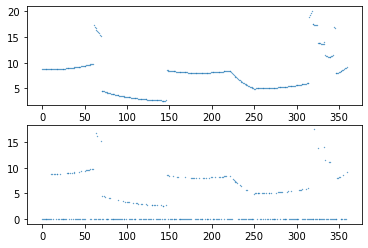

In [85]:
plt.figure(1)
plt.subplot(211)
plt.scatter([range(360)], [rangeList[1,:,0]], s=0.1, label="original")
plt.subplot(212)
plt.scatter([range(360)], [rangeList_compressed[1,:,0]], s=0.1, label="compressive")
# if Flag_compression:
#   for xc in indices:
#     plt.axvline(x=xc,c='r',linewidth=0.1,linestyle='-.')
    
plt.show()

# Section 2: Data Preparation

In [86]:
print(range_pairs[:,:,1].shape)
add_compression_network = True

(127570, 360)


In [87]:
from sklearn.utils import shuffle
#pose_rels_grid_all=np.hstack((np.expand_dims(pose_rels_grid, axis=1),np.expand_dims(rotation_rels, axis=1)))
def sigmoid(x):
  return x/40.0
  # return 1 / (1 + np.exp(-x))

# pose_rels_value_all=np.hstack((sigmoid(pose_rels),np.expand_dims(sigmoid(rotation_rels), axis=1)))
# pose_rels_value_all = range_pairs
# xs, ys = shuffle(range_pairs_compressed, pose_rels_value_all)
xs, ys_range = shuffle(sigmoid(np.clip(rangeList_compressed, a_min=None, a_max=40)), sigmoid(np.clip(rangeList, a_min=None, a_max=40)))

percent_of_trainSet=0.99*0.85
percent_of_validationSet=0.99*0.15
percent_of_testSet=0.01
num_of_trainSet=np.int(ys_range.shape[0]*percent_of_trainSet)
num_of_validationSet=np.int(ys_range.shape[0]*percent_of_validationSet)
num_of_testSet=np.int(ys_range.shape[0]*percent_of_testSet)

x_training = np.array(xs[0:num_of_trainSet], dtype=float)
y_range_training = np.array(ys_range[0:num_of_trainSet], dtype=float)
# y_pose_training = np.array(ys_pose[0:num_of_trainSet], dtype=float)
# y_training_ground_truth = np.array(ys_ground_truth[0:num_of_trainSet], dtype=float)
print('Size of training data: ', x_training.shape)
# print('Size of training labels: ',y_pose_training.shape)

x_validation = np.array(xs[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
y_range_validation = np.array(ys_range[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
# y_pose_validation = np.array(ys_pose[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
# y_validation_ground_truth = np.array(ys_ground_truth[num_of_trainSet:num_of_trainSet+num_of_validationSet], dtype=float)
print('Size of validation data: ', x_validation.shape)
# print('Size of validation labels: ',y_pose_validation.shape)

x_testing = np.array(xs[num_of_trainSet+num_of_validationSet:], dtype=float)
y_range_testing = np.array(ys_range[num_of_trainSet+num_of_validationSet:], dtype=float)
# y_pose_testing = np.array(ys_pose[num_of_trainSet+num_of_validationSet:], dtype=float)
# y_testing_ground_truth=np.array(ys_ground_truth[num_of_trainSet+num_of_validationSet:], dtype=float)
print('Size of testing data: ', x_testing.shape)
# print('Size of testing labels: ',y_pose_testing.shape)

Size of training data:  (107350, 360, 1)
Size of validation data:  (18944, 360, 1)
Size of testing data:  (1276, 360, 1)


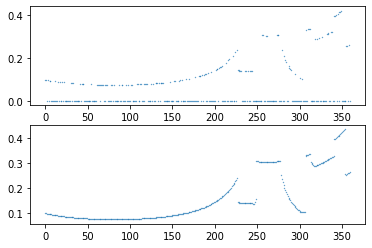

In [88]:
plt.figure(1)
plt.subplot(211)
plt.scatter([range(360)], [x_training[1,:,0]], s=0.1, label="original")
plt.subplot(212)
plt.scatter([range(360)], [y_range_training[1,:,0]], s=0.1, label="compressive")
# if Flag_compression:
#   for xc in indices:
#     plt.axvline(x=xc,c='r',linewidth=0.1,linestyle='-.')
    
plt.show()

# Section 3: Model Traning

In [89]:
BATCH_SIZE = 32
add_compression_network=True
if add_compression_network:
  training_dataset = tf.data.Dataset.from_tensor_slices((x_training,y_range_training)).batch(BATCH_SIZE)#
  validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, y_range_validation)).batch(BATCH_SIZE)         

In [90]:
print(x_training.shape,y_range_training.shape)

(107350, 360, 1) (107350, 360, 1)


In [91]:
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Add, AveragePooling1D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import Model
# 1D residual layer
def residual_block(input_data, input_channel=None, output_channel=None, kernel_size=3, stride=1, dilation_rate=1, drop_rate=0.0):
    if (input_channel is None):
        input_channel = input_data.shape[-1] # n_channel
    x = BatchNormalization()(input_data)
    x = Activation('relu')(x)
    x = Conv1D(input_channel, kernel_size=1, strides=stride, padding='valid', dilation_rate=dilation_rate, use_bias=False)(x) # input_channel
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(input_channel, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)(x) # input_channel
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(output_channel, kernel_size=1, strides=1, padding='same', use_bias=False)(x) # output_channel
    input_data = BatchNormalization()(input_data)
    input_data = Conv1D(output_channel, kernel_size=1, strides=stride, padding='valid', dilation_rate=dilation_rate,
                       use_bias=False)(input_data) # output_channel
    if drop_rate > 0:
        x = Dropout(drop_rate, noise_shape=(None, 1, None))(x)
#         x = Dropout(drop_rate)(x)
    output      = Add()([x, input_data]) # output_channel
    return output # (batch_size, seq_len, output_channel)


def Encoder_Decoder():
  # input size = (batch_size, 360, 1)
    input_data = Input(shape=(360, 1))
    x = input_data
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    x = tf.keras.layers.concatenate([x, mask])
    x = residual_block(x, output_channel=2, kernel_size=3, stride=1)
    x = residual_block(x, output_channel=4, kernel_size=3, stride=1)
    x = residual_block(x, output_channel=8, kernel_size=3, stride=1) # (360)

    x = residual_block(x, output_channel=16, kernel_size=3, stride=2) # (180)
    x = residual_block(x, output_channel=32, kernel_size=3, stride=2) # (90)
    x = residual_block(x, output_channel=64, kernel_size=3, stride=2) # (45)
    
    x = tf.keras.layers.UpSampling1D()(x) #(90)
    x = residual_block(x, output_channel=64, kernel_size=3, stride=1) # (90)
    x = tf.keras.layers.UpSampling1D()(x) #(180)
    x = residual_block(x, output_channel=64, kernel_size=3, stride=1) # (180)
    x = tf.keras.layers.UpSampling1D()(x) #(360)
    x = residual_block(x, output_channel=64, kernel_size=3, stride=1) # (360)
    
    output = residual_block(x, output_channel=1, kernel_size=3, stride=1) # (360)
    model = Model(inputs=input_data, outputs=[output])
    
    return model


check if the soft-argmax function is working

In [92]:
import tensorflow.keras.backend as kb
from tensorflow.keras.losses import MSE
from tensorflow import stack,argmax,cast

dropout_rate=0.2
optimizer_lr=0.001
model = Encoder_Decoder()
optimizer = tf.keras.optimizers.Adam(optimizer_lr)
if add_compression_network:
  model.compile(optimizer=optimizer,
                  loss=keras.losses.mse,
                  metrics= tf.keras.metrics.MeanAbsoluteError())
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 360, 1)]     0                                            
__________________________________________________________________________________________________
tf.math.equal_1 (TFOpLambda)    (None, 360, 1)       0           input_7[0][0]                    
__________________________________________________________________________________________________
tf.cast_1 (TFOpLambda)          (None, 360, 1)       0           tf.math.equal_1[0][0]            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 360, 2)       0           input_7[0][0]                    
                                                                 tf.cast_1[0][0]            

In [93]:
# lr decay function
def lr_decay(epoch):
  return 0.001 * math.pow(0.9, np.floor(epoch/5))
# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

EPOCHS=100
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=7, restore_best_weights=True, verbose=1)
model.fit(training_dataset, validation_data=validation_dataset, epochs=EPOCHS, callbacks=[early_stopper,lr_decay_callback])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
3355/3355 [==============================] - 155s 43ms/step - loss: 0.0335 - mean_absolute_error: 0.0706 - val_loss: 8.7323e-04 - val_mean_absolute_error: 0.0178
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
3355/3355 [==============================] - 141s 42ms/step - loss: 0.0012 - mean_absolute_error: 0.0191 - val_loss: 4.9632e-04 - val_mean_absolute_error: 0.0098
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
3355/3355 [==============================] - 141s 42ms/step - loss: 8.1473e-04 - mean_absolute_error: 0.0148 - val_loss: 6.0607e-04 - val_mean_absolute_error: 0.0160
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
3355/3355 [==============================] - 145s 43ms/step - loss: 7.0054e-04 - mean_absolute_error: 0.0135 - val_loss: 4.1035e-04 - val_mean_absolute_error: 0.0121
Epoch 5/100

Epoch 0

# Section 4: Model Evaluation

In [56]:
model.evaluate(validation_dataset)

592/592 [==============================] - 5s 9ms/step - loss: 3.9134e-04 - mean_absolute_error: 0.0075


[0.0003913420077878982, 0.0075476160272955894]

In [ ]:
# model.save("model_regression")
# from google.colab import files
# !zip -r model_regression.zip model_regression/
# files.download('model_regression.zip')

In [57]:
#evaluate model accuracy using testing dataset
testing_dataset = tf.data.Dataset.from_tensor_slices((x_testing, y_range_testing)).batch(BATCH_SIZE)
model.evaluate(testing_dataset)

40/40 [==============================] - 0s 10ms/step - loss: 3.6292e-04 - mean_absolute_error: 0.0074


[0.0003629191778600216, 0.007374538574367762]

In [95]:
y_predict=model.predict(x_testing)
print(y_predict[0].shape)

(360, 1)


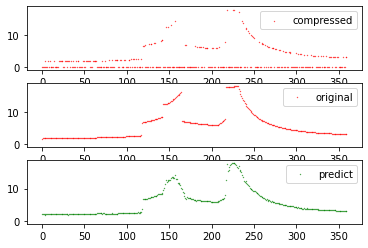

In [104]:
test_idx = 20
mask_imcomplete = np.ones((x_testing[0].shape[0],1))
mask_imcomplete[np.where(x_testing[test_idx]==0)]=0
y_filled_with_predict = y_range_testing[test_idx]*mask_imcomplete+y_predict[test_idx]*(1-mask_imcomplete)
plt.figure(1)
ax1=plt.subplot(311)
ax1.scatter([range(360)], x_testing[test_idx]*40.0, color='r', s=0.1, label="compressed")
ax1.legend(loc='upper right')
# plt.scatter([range(360)], y_filled_with_predict*40.0, color='g',s=0.1, label="filled_with_predict")
ax2=plt.subplot(312,sharex=ax1,sharey=ax1)
ax2.scatter([range(360)], y_range_testing[test_idx]*40.0,color='r', s=0.1, label="original")
ax3=plt.legend(loc='upper right')
ax3=plt.subplot(313,sharex=ax1,sharey=ax1)
ax3.scatter([range(360)], y_filled_with_predict*40.0, color='g',s=0.1, label="predict")
ax3.legend(loc='upper right') 
# if Flag_compression:
#   for xc in indices:
#     plt.axvline(x=xc,c='r',linewidth=0.1,linestyle='-.')
  
plt.show()

## Visualize feature map

(7, 2, 64)


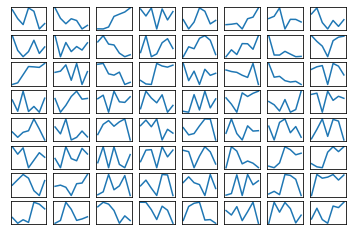

In [ ]:
# kernels in first conv layer
filters, biases = model.layers[1].get_weights()
print(np.shape(filters))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.plot(filters[:,0,ix-1])
		ix += 1
# show the figure
plt.show()

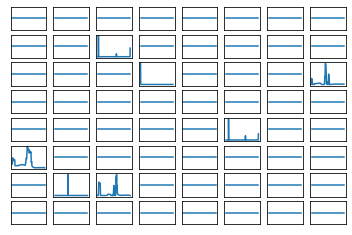

In [ ]:
# define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# run our image through our network, thus obtaining all
# intermediate representations for this range data.
successive_feature_maps = visualization_model.predict(x_training[0:5])
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
visualization_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps = visualization_model.predict(np.expand_dims(x_training[500], axis=0))
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.plot(feature_maps[0, :, ix-1])
		ix += 1
# show the figure
plt.show()

## Odometry-based Localization

In [ ]:
!gdown --id 1Jq9xPARjAEY8DmJL0Q5uvFSOVHo-bwkf #simple wall
#!gdown --id 1IyOf-VK_8eqDl00seI36Eo_FIcThVqio #simple maze:
world_name = 'simple_wall'
local_zip = 'test_'+world_name+'.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test_'+world_name)
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1Jq9xPARjAEY8DmJL0Q5uvFSOVHo-bwkf
To: /content/test_simple_wall.zip
100% 1.66M/1.66M [00:00<00:00, 110MB/s]


In [ ]:
with open('test_'+world_name+'/test_simple_range_pairs_3.pickle', 'rb') as handle:
    test_simple_range_pairs = pickle.load(handle)

with open('test_'+world_name+'/test_simple_pose_rels_3.pickle', 'rb') as handle:
    test_simple_pose_rels = pickle.load(handle)
test_simple_range_pairs = np.swapaxes(test_simple_range_pairs, 1, 2)
test_simple_range_pairs = test_simple_range_pairs[:,::2,:]
test_simple_range_pairs = test_simple_range_pairs[:,90:451,:]
test_simple_translation_rels=test_simple_pose_rels[:,0:2]
test_simple_rotation_rels=test_simple_pose_rels[:,2]
print("size of range_pairs: ", test_simple_range_pairs.shape)
print("size of pose_rels: ", test_simple_translation_rels.shape)
print("size of rotation_rels: ", test_simple_rotation_rels.shape)

size of range_pairs:  (243, 361, 2)
size of pose_rels:  (243, 2)
size of rotation_rels:  (243,)


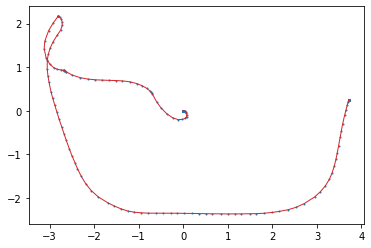

In [ ]:
from matplotlib.animation import FuncAnimation
def rels_to_abs(pose_rels):
    pose_i = np.array([[0],[0]])
    poses = pose_i.T
    theta_i = 0.0
    for i in range(pose_rels.shape[0]):
        [rels_x,rels_y,rels_theta] = pose_rels[i,0:3]
        T_matrix = np.array([[np.cos(theta_i),-np.sin(theta_i)],[np.sin(theta_i),np.cos(theta_i)]])
        pose_ic =np.dot(T_matrix,np.array([[rels_x],[rels_y]]))+pose_i
        poses = np.concatenate((poses,pose_ic.T))
        pose_i = pose_ic
        if isinstance(rels_theta,np.ndarray):
          theta_i += rels_theta[0,0]
        else:
          theta_i += rels_theta
    return poses

dataSet = rels_to_abs(np.array(test_simple_pose_rels))
plt.plot(dataSet[:,0],dataSet[:,1], 'C3', lw=1)
plt.scatter(dataSet[:,0],dataSet[:,1], s=1)


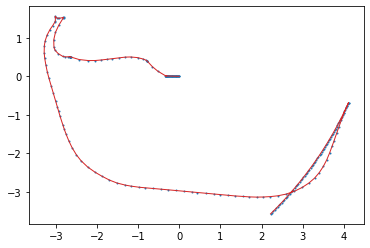

In [ ]:
from matplotlib.animation import FuncAnimation
test_pose_predict=model.predict(test_simple_range_pairs[0:-1,:])
predict_test_translation_value = np.array(test_pose_predict[0])
predict_test_rotation_value=np.expand_dims(np.array(tf.squeeze(test_pose_predict[1])), axis=1)*np.pi/180
predict_test_pose = np.concatenate((predict_test_translation_value,predict_test_rotation_value),axis=-1)
dataSet_estimate = rels_to_abs(np.array(predict_test_pose))
# dataSet_ground_truth = rels_to_abs(np.array(test_simple_pose_rels))
plt.plot(dataSet_estimate[:,0],dataSet_estimate[:,1], 'C3', lw=1)
plt.scatter(dataSet_estimate[:,0],dataSet_estimate[:,1], s=1)

compare ground-truth trajectory with predicted trajector

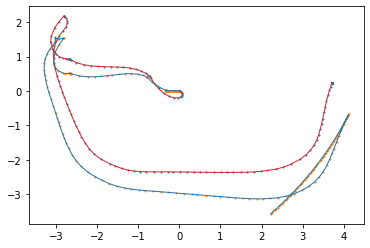

In [ ]:
plt.plot(dataSet[:,0],dataSet[:,1], 'C3', lw=1)
plt.scatter(dataSet[:,0],dataSet[:,1], s=1)

plt.plot(dataSet_estimate[:,0],dataSet_estimate[:,1], 'C10', lw=1)
plt.scatter(dataSet_estimate[:,0],dataSet_estimate[:,1], s=1)

In [ ]:
for i in range(100):
  predict_i=list(np.round(predict_test_translation_value[i],4))
  predict_i.append(np.round(np.float(predict_test_rotation_value[i]),4))
  if i%1==0:
    print("test: ", i, " ground_truth: ", np.round(np.double(test_simple_pose_rels[i,:]),4),
          " predicted: ",predict_i)

test:  0  ground_truth:  [-0. -0.  0.]  predicted:  [-0.0078, 0.0002, 0.0006]
test:  1  ground_truth:  [ 0. -0.  0.]  predicted:  [-0.0068, 0.0002, 0.0002]
test:  2  ground_truth:  [0. 0. 0.]  predicted:  [-0.0066, 0.0002, 0.0005]
test:  3  ground_truth:  [-0.  0.  0.]  predicted:  [-0.0073, 0.0002, 0.0003]
test:  4  ground_truth:  [-0. -0.  0.]  predicted:  [-0.0093, 0.0003, 0.0006]
test:  5  ground_truth:  [0. 0. 0.]  predicted:  [-0.0059, 0.0002, 0.0]
test:  6  ground_truth:  [-0.  0.  0.]  predicted:  [-0.0091, 0.0003, 0.0006]
test:  7  ground_truth:  [-0. -0.  0.]  predicted:  [-0.0085, 0.0003, 0.0005]
test:  8  ground_truth:  [0. 0. 0.]  predicted:  [-0.0069, 0.0002, 0.0003]
test:  9  ground_truth:  [-0.  0.  0.]  predicted:  [-0.0083, 0.0002, 0.0005]
test:  10  ground_truth:  [0. 0. 0.]  predicted:  [-0.0059, 0.0002, 0.0005]
test:  11  ground_truth:  [-0.  0.  0.]  predicted:  [-0.0069, 0.0002, 0.0006]
test:  12  ground_truth:  [-0. -0.  0.]  predicted:  [-0.0071, 0.0003, 0.0001

# Section 5: Load Saved Model

In [ ]:
model.save_weights('./model_weights_0404_361samples/base_model_weights', save_format='tf')
!zip -r model_weights_0404_361samples.zip model_weights_0404_361samples/

  adding: model_weights_0404_361samples/ (stored 0%)
  adding: model_weights_0404_361samples/base_model_weights.data-00000-of-00001 (deflated 34%)
  adding: model_weights_0404_361samples/checkpoint (deflated 43%)
  adding: model_weights_0404_361samples/base_model_weights.index (deflated 76%)


In [ ]:
from google.colab import files
files.download('model_weights_0404_361samples.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>